# Generative Adversarial Networks in 3 x 3 

Special thanks to Luis Serrano for a friendly introduction to GANs.
https://github.com/luisguiserrano

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import os
import sys

In [4]:
X = [np.array([0,1,0, 1,1,1,0,1,0]),
     np.array([0,0.8,0, 0.75,0.7,0.8,0,0.6,0]),
     np.array([0.3,0.8,0.2, 0.75,0.7,0.8,0.1,0.8,0.25]),
     np.array([0.1,0.7,0.2, 0.76,0.7,0.8,0.1,0.9,0.2]),
     np.array([0,0.6,0, 0.75,0.7,0.8,0,0.8,0]),
     np.array([0.2,0.7,0.2, 0.7,0.8,0.6,0.1,0.8,0.25]),
     np.array([0,1,0, 1,1,1,0,1,0]),
     np.array([0,1,0, 1,1,1,0,1,0]),
     np.array([0,1,0, 1,1,1,0,1,0])]
X = np.array(X)
X = 1 - X


In [5]:
print(X.shape)

(9, 9)


In [6]:
X = X.reshape([-1, 3,3])
print(X.shape)

(9, 3, 3)


In [7]:
N, H, W = X.shape
D = H * W 

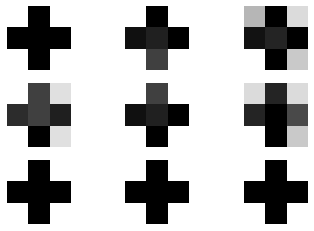

In [9]:
rows = 3
columns = 3
fig, ax = plt.subplots(rows, columns)
index = 0
for i in range(rows):
  for j in range(columns):
    ax[i,j].imshow(X[index].reshape(H,W), cmap='gray')
    ax[i,j].axis('off')
    index+=1

In [10]:
X_train = X.reshape(-1, D)

In [11]:
print(X.shape)
print(X_train.shape)

(9, 3, 3)
(9, 9)


In [12]:
LD = 9

In [13]:
def make_generator(LD, D):
  i_layer = Input(shape=(LD,))
  h_layer = Dense(9, activation='sigmoid')(i_layer)
  h_layer = Dense(9, activation='sigmoid')(h_layer)
  o_layer = Dense(D, activation='sigmoid')(h_layer)
  return Model(i_layer, o_layer)

In [14]:
def make_discriminator(D):
  i_layer = Input(shape=(D,))
  h_layer = Dense(9, activation='sigmoid')(i_layer)
  h_layer = Dense(9, activation='sigmoid')(h_layer)
  o_layer = Dense(1, activation='sigmoid')(h_layer)
  return Model(i_layer, o_layer)

In [15]:
d = make_discriminator(D)

In [16]:
d.compile(loss='binary_crossentropy',
          optimizer = Adam(0.01),
          metrics = ['accuracy'])

In [17]:
g = make_generator(LD, D)

In [18]:
noise_i_layer = Input(shape=(LD,))
image = g(noise_i_layer, D)
d.trainable = False
prediction = d(image)
gan = Model(noise_i_layer, prediction)

In [19]:
gan.compile(loss='binary_crossentropy',
          optimizer = Adam(0.01))

In [20]:
batch_size = 1
epochs = 200
export_period = 50

In [21]:
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

In [22]:
d_loss_list = []
g_loss_list = []

In [23]:
if not os.path.exists('GANS'):
  os.makedirs('GANS')

In [24]:
def get_images(epochs, rows, columns, LD, g):
  noise = np.random.randn(rows * columns, LD)
  images_by_generator = g.predict(noise)
  images_by_generator = 0.5 * images_by_generator + 0.5

  fig, ax = plt.subplots(rows, columns)
  index = 0
  for i in range(rows):
    for j in range(columns):
      ax[i,j].imshow(images_by_generator[index].reshape(H,W), cmap='gray')
      ax[i,j].axis('off')
      index+=1
  fig.savefig("GANS/%d.png" % epochs)
  plt.close

epoch = 0 d_loss = 0.8079031556844711 and g_loss = 0.37892863154411316


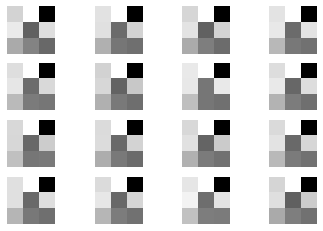

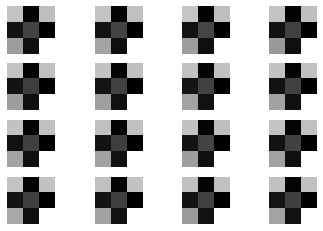

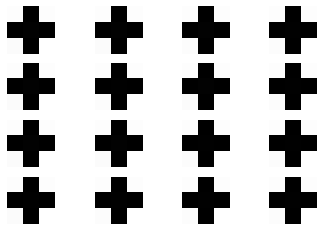

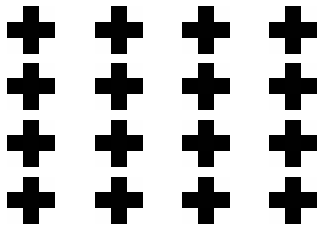

In [25]:
for e in range(epochs):
  index = np.random.randint(0, X_train.shape[0], batch_size)
  real = X_train[index]

  noise = np.random.randn(batch_size, LD)
  fake = g.predict(noise)

  d_loss_real, d_accuracy_real = d.train_on_batch(real, ones)
  d_loss_fake, d_accuracy_fake= d.train_on_batch(fake, zeros)
  d_loss = (d_loss_real + d_loss_fake) * 1/2 
  d_accuracy = (d_loss_real + d_loss_fake) * 1/2


  noise = np.random.randn(batch_size, LD)
  g_loss = gan.train_on_batch(noise, ones)

  d_loss_list.append(d_loss)
  g_loss_list.append(g_loss)

  if e % 200 == 0:
    print("epoch = {} d_loss = {} and g_loss = {}".format(e, d_loss, g_loss))
  if e % export_period == 0:
    get_images(e , 4,4, LD, g)

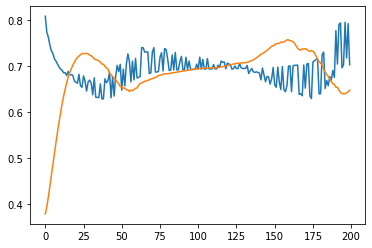

In [26]:
plt.plot(d_loss_list)
plt.plot(g_loss_list)
plt.show()